## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder
%matplotlib inline


from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
import time


In [2]:
df = pd.read_csv("../input/altai-data/train_dataset_train.csv")
df_test = pd.read_csv("../input/altai-test-data/test_dataset_test.csv")
df_submission = pd.read_csv("../input/altai-sample/sample_submission.csv")

## Рассмотрим датасет по ближе

In [3]:
df.head().T

,0,1,2,3,4
ID,72716,63306,82469,81661,81509
Код_группы,16019,14895,20103,19838,19803
Год_Поступления,2015,2010,2017,2017,2017
Пол,Жен,Муж,Жен,Жен,Жен
Основания,ОО,ЦН,ДН,БН,БН
Изучаемый_Язык,Английский язык,NaN,Английский язык,Английский язык,Английский язык
Дата_Рождения,1998-02-08 00:00:00.000,1992-04-18 00:00:00.000,1999-03-21 00:00:00.000,1994-12-08 00:00:00.000,1995-06-28 00:00:00.000
Уч_Заведение,"МБОУ ""СОШ №59""",NaN,МБОУ Алтайская СОШ №5,ФГБОУ ВО Алтайский государственный университет,ФГБОУ ВО Алтайский государственный университет
Где_Находится_УЗ,"Алтайский край, Барнаул г",NaN,"Алтайский край, Алтайский р-н, Алтайское с","Алтайский край, г. Барнаул","Алтайский край, г. Барнаул"
Год_Окончания_УЗ,2014.0,NaN,2017.0,2017.0,2017.0


In [4]:
df.shape

(13584, 24)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13584 entries, 0 to 13583
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                13584 non-null  int64  
 1   Код_группы        13584 non-null  int64  
 2   Год_Поступления   13584 non-null  int64  
 3   Пол               13577 non-null  object 
 4   Основания         13584 non-null  object 
 5   Изучаемый_Язык    12758 non-null  object 
 6   Дата_Рождения     13584 non-null  object 
 7   Уч_Заведение      12351 non-null  object 
 8   Где_Находится_УЗ  12203 non-null  object 
 9   Год_Окончания_УЗ  12284 non-null  float64
 10  Пособие           12576 non-null  float64
 11  Страна_ПП         13237 non-null  object 
 12  Регион_ПП         12966 non-null  object 
 13  Город_ПП          13141 non-null  object 
 14  Общежитие         13498 non-null  float64
 15  Наличие_Матери    13584 non-null  int64  
 16  Наличие_Отца      13584 non-null  float6

Заменим все пропуски в данных

In [6]:
# Агрегируем данные по датафрейму в одну таблицу
features_data = pd.DataFrame(index=df.columns)

# Корреляция с таргетом
train_corr = df.corr()
#features_data['Customer Lifetime Value Cor'] = train_corr['Customer Lifetime Value']
# Тип данных
features_data['Type'] = df.dtypes
# Пропущенные данные
features_data['NaN'] = df.isna().sum()
features_data['NaN percent'] = (df.isna().sum() / df.shape[0]) * 100
# Уникальные значения
features_data['Unique'] = pd.DataFrame([len(df[item].unique()) for item in df.columns], index=features_data.index) 
# Статистика
quantiles = [0.05, 0.50, 0.95]
features_train_desc = df.describe(quantiles).T
features_data = features_data.join(features_train_desc, how='left')

#features_data.drop('Customer Lifetime Value', axis=0, inplace=True)
features_data

,Type,NaN,NaN percent,Unique,count,mean,std,min,5%,50%,95%,max
ID,int64,0,0.000000,13584,13584.0,70096.056905,12705.894531,44632.0,48410.15,71401.5,88328.7,264403.0
Код_группы,int64,0,0.000000,3653,13584.0,18302.499926,2540.417956,11550.0,13601.00,18534.5,21868.0,22824.0
Год_Поступления,int64,0,0.000000,19,13584.0,2014.992123,2.595339,2001.0,2012.00,2015.0,2018.0,2212.0
Пол,object,7,0.051531,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Основания,object,0,0.000000,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Изучаемый_Язык,object,826,6.080683,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Дата_Рождения,object,0,0.000000,5044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Уч_Заведение,object,1233,9.076855,3647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Где_Находится_УЗ,object,1381,10.166372,2111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Год_Окончания_УЗ,float64,1300,9.570082,43,12284.0,2013.876018,4.247111,1973.0,2005.00,2015.0,2018.0,2020.0


Пострим на распределение данных

Text(0.5, 1.0, 'Распределение предсказываемой величены')

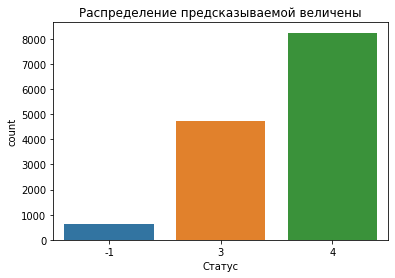

In [7]:
sns.countplot(x = "Статус" , data  = df).set_title('Распределение предсказываемой величены')

Text(0.5, 1.0, 'Распределение года поступления')

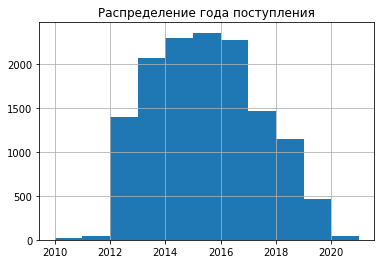

In [8]:
df["Год_Поступления"].hist(bins = 11, range = [2010, 2021]).set_title('Распределение года поступления')

Взглянем на несколько величин сразу

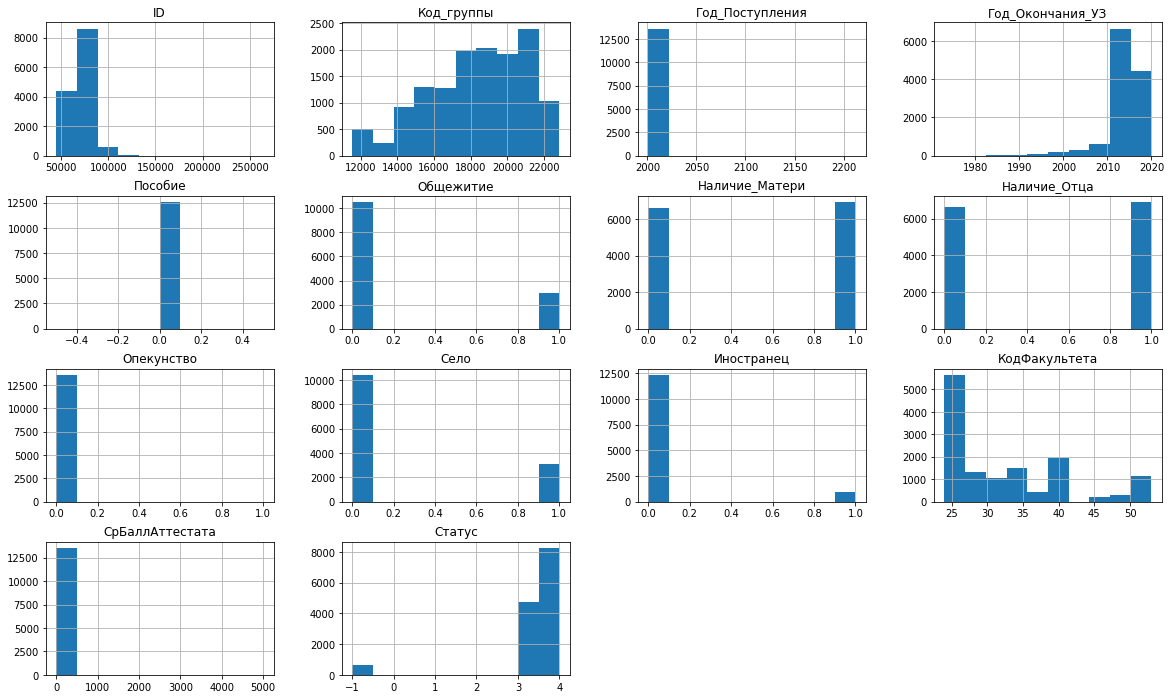

In [9]:
_ = df[df.columns].hist(figsize=(20,12))

Обратим внимание на часть столбцов с постоянными значениями

In [10]:
df["Пособие"].value_counts()

0.0    12576
Name: Пособие, dtype: int64

In [11]:
df["Опекунство"].value_counts()

0.0    13578
1.0        6
Name: Опекунство, dtype: int64

In [12]:
df.columns.values

array(['ID', 'Код_группы', 'Год_Поступления', 'Пол', 'Основания',
       'Изучаемый_Язык', 'Дата_Рождения', 'Уч_Заведение',
       'Где_Находится_УЗ', 'Год_Окончания_УЗ', 'Пособие', 'Страна_ПП',
       'Регион_ПП', 'Город_ПП', 'Общежитие', 'Наличие_Матери',
       'Наличие_Отца', 'Страна_Родители', 'Опекунство', 'Село',
       'Иностранец', 'КодФакультета', 'СрБаллАттестата', 'Статус'],
      dtype=object)

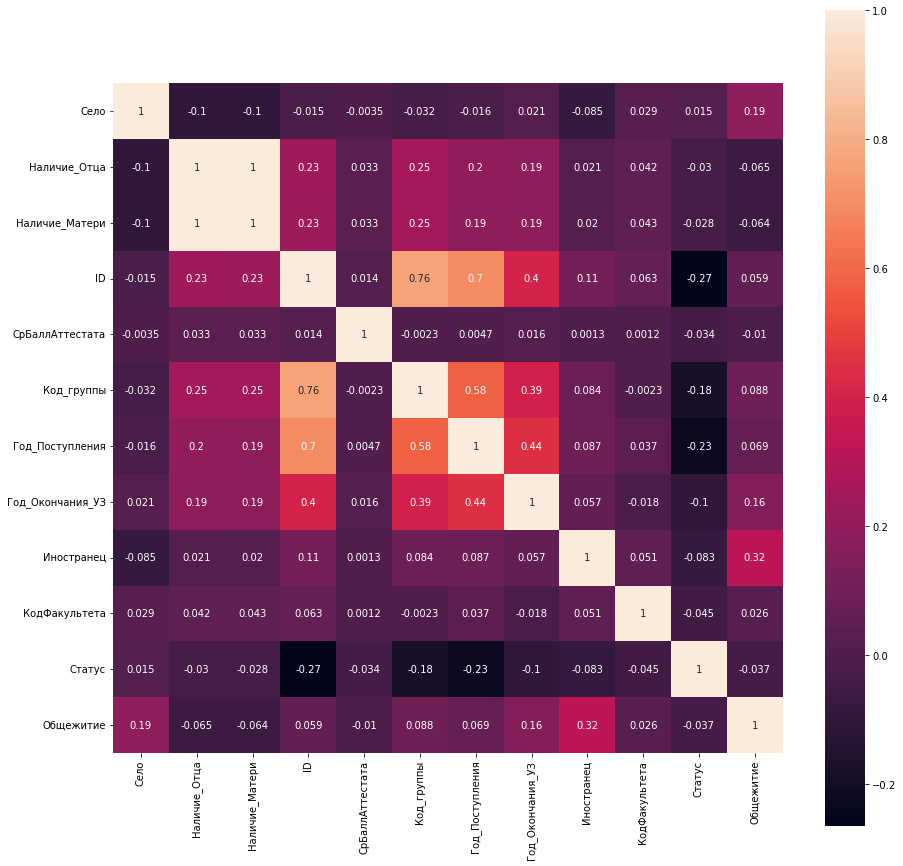

In [13]:
plt.rcParams['figure.figsize']=(15,15)


df_corr = list(set(df.columns.values) - set(['Опекунство','Пособие']))
g = sns.heatmap(df[df_corr].corr(), square = True, annot=True)

In [14]:
features_data

,Type,NaN,NaN percent,Unique,count,mean,std,min,5%,50%,95%,max
ID,int64,0,0.000000,13584,13584.0,70096.056905,12705.894531,44632.0,48410.15,71401.5,88328.7,264403.0
Код_группы,int64,0,0.000000,3653,13584.0,18302.499926,2540.417956,11550.0,13601.00,18534.5,21868.0,22824.0
Год_Поступления,int64,0,0.000000,19,13584.0,2014.992123,2.595339,2001.0,2012.00,2015.0,2018.0,2212.0
Пол,object,7,0.051531,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Основания,object,0,0.000000,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Изучаемый_Язык,object,826,6.080683,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Дата_Рождения,object,0,0.000000,5044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Уч_Заведение,object,1233,9.076855,3647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Где_Находится_УЗ,object,1381,10.166372,2111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Год_Окончания_УЗ,float64,1300,9.570082,43,12284.0,2013.876018,4.247111,1973.0,2005.00,2015.0,2018.0,2020.0


In [15]:
df.head().T

,0,1,2,3,4
ID,72716,63306,82469,81661,81509
Код_группы,16019,14895,20103,19838,19803
Год_Поступления,2015,2010,2017,2017,2017
Пол,Жен,Муж,Жен,Жен,Жен
Основания,ОО,ЦН,ДН,БН,БН
Изучаемый_Язык,Английский язык,NaN,Английский язык,Английский язык,Английский язык
Дата_Рождения,1998-02-08 00:00:00.000,1992-04-18 00:00:00.000,1999-03-21 00:00:00.000,1994-12-08 00:00:00.000,1995-06-28 00:00:00.000
Уч_Заведение,"МБОУ ""СОШ №59""",NaN,МБОУ Алтайская СОШ №5,ФГБОУ ВО Алтайский государственный университет,ФГБОУ ВО Алтайский государственный университет
Где_Находится_УЗ,"Алтайский край, Барнаул г",NaN,"Алтайский край, Алтайский р-н, Алтайское с","Алтайский край, г. Барнаул","Алтайский край, г. Барнаул"
Год_Окончания_УЗ,2014.0,NaN,2017.0,2017.0,2017.0


In [16]:

#enc_school = OrdinalEncoder(handle_unknown='error', unknown_value=None, encoded_missing_value=0, )
#enc_school.fit(df[["Уч_Заведение"]])

In [17]:

#print(df["Где_Находится_УЗ"].unique())
#df["Где_Находится_УЗ"].value_counts().head(50)
#df[df["СрБаллАттестата"]>100]["СрБаллАттестата"].value_counts() 

#df["Год_Окончания_УЗ"] Барнаул, Бийск Новоалтайск Горно-Алтайск Рубцовск Заринск Москва Славгород Семей Камень-на-Оби

In [18]:
from collections import defaultdict



def data_preprocessing(data_input):
    
    # ID
    #data_input = data_input.drop("ID", axis=1)
    
    # Код_группы
    #data_input = data_input.drop("Код_группы", axis=1)  
    
    # Год_Поступления
    # norm
    temp = data_input[data_input['Год_Поступления'] > 2022]
    data_input.loc[temp.index, 'Год_Поступления'] = 2015
    
    # Пол
    data_input.loc[:, 'Пол'] = data_input["Пол"].fillna("no_data")
    data_input.loc[:, 'Пол'] = data_input["Пол"].replace({'no_data': 0, 'Жен': 1, 'жен': 1, 'Муж': 2, 'муж': 2})
    data_input = pd.get_dummies(data_input, columns=['Пол'], prefix_sep='=')
    
    # Основания
    data_input = pd.get_dummies(data_input, columns=['Основания'], prefix_sep='=')
    
    # Изучаемый_Язык
    data_input.loc[:, 'Изучаемый_Язык'] = data_input["Изучаемый_Язык"].fillna("no_data")
    
    lang_dict_0 = {'no_data': 0, 
                 'Английский язык': 1,
                 'Немецкий язык': 2,
                 'Французский язык': 3,
                 'Русский язык':4,
                 'Иностранный язык (Английский)' :1,
                 'Иностранный язык (Немецкий)' :2,
                 'Иностранный язык (Французский)' :3,
                 'Англиийский':1,
                 'Англиийский':2,
                 'Французский':3}
    
    lang_dict = defaultdict(lambda: 0, lang_dict_0)
    
    data_input.loc[:, 'Изучаемый_Язык'] = data_input["Изучаемый_Язык"].apply(lambda a: lang_dict[a])
    #data_input = data_input.drop("Изучаемый_Язык", axis=1)
    data_input = pd.get_dummies(data_input, columns=['Изучаемый_Язык'], prefix_sep='=')
    
    # Дата_Рождения
    data_input.loc[:, 'Дата_Рождения'] = pd.to_datetime(data_input["Дата_Рождения"]).dt.year
    
    # Уч_Заведение
    data_input.loc[:, 'Уч_Заведение'] = data_input["Уч_Заведение"].fillna("no_data")
    #data_input = pd.get_dummies(data_input, columns=['Уч_Заведение'], prefix_sep='=')
    
    data_input.loc[:, 'Уч_Зав_университет'] = df["Уч_Заведение"].str.find("университет") > 0
    data_input.loc[:, 'Уч_Зав_Гимназия'] = df["Уч_Заведение"].str.find("Гимназия") > 0
    data_input.loc[:, 'Уч_Зав_СОШ'] = df["Уч_Заведение"].str.find("СОШ") > 0
    data_input.loc[:, 'Уч_Зав_Лицей'] = df["Уч_Заведение"].str.find("Лицей") > 0
    data_input.loc[:, 'Уч_Зав_колледж'] = df["Уч_Заведение"].str.find("колледж") > 0
    data_input.loc[:, 'Уч_Зав_академия'] = df["Уч_Заведение"].str.find("академия") > 0

    data_input = data_input.drop("Уч_Заведение", axis=1)
    
    # Где_Находится_УЗ
    data_input.loc[:, 'Где_Находится_УЗ'] = data_input["Где_Находится_УЗ"].fillna("no_data")
    #data_input = pd.get_dummies(data_input, columns=['Уч_Заведение'], prefix_sep='=')
        
    for town in ["Барнаул", "Бийск", "Новоалтайск", "Славгород", "Рубцовск", "Заринск", "Камень-на-Оби", "Горно-Алтайск", "Семей", "Москва"]:
        data_input.loc[:, 'Где_Находится_УЗ_'+town] = df["Где_Находится_УЗ"].str.find(town) >= 0

    data_input = data_input.drop("Где_Находится_УЗ", axis=1)
    
    # Год_Окончания_УЗ
    data_input.loc[:, 'Год_Окончания_УЗ'] = data_input["Год_Окончания_УЗ"].fillna(data_input["Год_Окончания_УЗ"].median())
    #data_input = pd.get_dummies(data_input, columns=['Уч_Заведение'], prefix_sep='=')
    #data_input = data_input.drop("Год_Окончания_УЗ", axis=1)    
    
    # Пособие
    #data_input = data_input.drop("Пособие", axis=1)
    data_input.loc[:, 'Пособие'] = data_input["Пособие"].fillna(0)
    
    # Страна_ПП
    data_input.loc[:, 'Страна_ПП'] = data_input["Страна_ПП"].fillna("no_data")
    
    country_dict_0 = {'no_data': 0, 
        'Россия' : 1,
        'Казахстан': 2,
        'Кыргызстан':3,
        'Китай':4,
        'Таджикистан':5,
        'Казахстан Респ':2,
        'Киргизия':3,
        'Казахстан респ':2,
        'РОССИЯ':2,
        'Армения':0,
        'Туркменистан':6,
        'Нигерия':0,
        'Таджикистан Респ':5,
        'Росссия':1,
        'Узбекистан':0,
        'Кыргызия':0,
        'Франция':2,
        'Кыргызская Республика':3,
        'Монголия':0,
        'Казахстан ВКО':2,
        'Республика Казахстан':2,
        'Республика Таджикистан':5,
        'Украина':0,
        'КАЗАХСТАН':2,
        'Китай':4,
        'Афганистан':0
        }
    country_dict = defaultdict(lambda: 0, country_dict_0) 
    
    
    data_input.loc[:, 'Страна_ПП'] = data_input["Страна_ПП"].apply(lambda a: country_dict[a])
    #data_input = data_input.drop("Страна_ПП", axis=1)
    data_input = pd.get_dummies(data_input, columns=['Страна_ПП'], prefix_sep='=')
    
    
    # Регион_ПП
    data_input = data_input.drop("Регион_ПП", axis=1)
    
    # Город_ПП
    
    for town in ["Барнаул", "Бийск", "Новоалтайск", "Славгород", "Рубцовск", "Заринск", "Камень-на-Оби", "Горно-Алтайск"]:
        data_input.loc[:, 'Город_ПП_'+town] = df["Город_ПП"].str.find(town) >= 0
    data_input = data_input.drop("Город_ПП", axis=1)
    
    
    # Общежитие
    data_input.loc[:, 'Общежитие'] = data_input["Общежитие"].fillna(-1)
    
    # Наличие_Матери
    #ok
    
    # Наличие_Отца
    data_input = data_input.drop("Наличие_Отца", axis=1)
    #ok
    
    # Страна_Родители
    data_input = data_input.drop("Страна_Родители", axis=1)
    
    # Опекунство
    data_input = data_input.drop("Опекунство", axis=1)
    
    # Село
    data_input.loc[:, 'Село'] = data_input["Село"].fillna(0)
    
    # Иностранец
    data_input.loc[:, 'Иностранец'] = data_input["Иностранец"].fillna(0)
    
    # КодФакультета
    #data_input = data_input.drop("КодФакультета", axis=1)
    #data_input = pd.get_dummies(data_input, columns=['КодФакультета'], prefix_sep='=')
    
    # СрБаллАттестата
    
    data_input.loc[data_input[data_input["СрБаллАттестата"]>100].index, "СрБаллАттестата"] = 0
    data_input.loc[:, 'СрБаллАттестата'] = data_input['СрБаллАттестата'].apply(lambda a: a/100 if a>5 else a/5)
    
    # Статус
    
    
    return data_input

train_df_full = data_preprocessing(df)

train_df_full.head().T

,0,1,2,3,4
ID,72716,63306,82469,81661,81509
Код_группы,16019,14895,20103,19838,19803
Год_Поступления,2015,2010,2017,2017,2017
Дата_Рождения,1998,1992,1999,1994,1995
Год_Окончания_УЗ,2014.0,2015.0,2017.0,2017.0,2017.0
Пособие,0.0,0.0,0.0,0.0,0.0
Общежитие,0.0,0.0,0.0,0.0,0.0
Наличие_Матери,0,1,1,1,1
Село,0.0,0.0,0.0,0.0,0.0
Иностранец,0.0,0.0,0.0,0.0,0.0


In [19]:
print(df.shape, df_test.shape)
all_df = df.append(df_test)

all_df_processed = data_preprocessing(all_df)

train_df_full = all_df_processed.iloc[:df.shape[0],:]
test_df_full = all_df_processed.iloc[df.shape[0]:,:]
print(train_df_full.shape, test_df_full.shape)

(13584, 24) (6691, 23)
(13584, 58) (6691, 58)


In [20]:
#all_df_processed.head().T

In [21]:
#df_corr = list(set(df.columns.values) - set(['Опекунство','Пособие']))
train_df_full.corr()["Статус"]

ID                               -0.265286
Код_группы                       -0.184447
Год_Поступления                  -0.305537
Дата_Рождения                    -0.076870
Год_Окончания_УЗ                 -0.091926
Пособие                                NaN
Общежитие                        -0.035483
Наличие_Матери                   -0.028311
Село                              0.015433
Иностранец                       -0.082560
КодФакультета                    -0.045014
СрБаллАттестата                   0.086213
Статус                            1.000000
Пол=0                             0.000045
Пол=1                             0.127892
Пол=2                            -0.127921
Основания=БН                      0.120173
Основания=ДН                      0.081207
Основания=ЛН                           NaN
Основания=ОО                     -0.078934
Основания=СН                     -0.073143
Основания=ЦН                      0.027320
Изучаемый_Язык=0                  0.065174
Изучаемый_Я

## Выделим выборки

In [22]:
train_df, valid_df = train_test_split(train_df_full, test_size=0.2, stratify=train_df_full["Статус"], random_state=32)
print(train_df.shape, valid_df.shape)

(10867, 58) (2717, 58)


In [23]:
# upsampling

status_3 = train_df[train_df_full["Статус"] == 3.0]
train_df = train_df.append(status_3)


status_ninus = train_df[train_df_full["Статус"] == -1.0]
train_df = train_df.append(status_ninus)
train_df = train_df.append(status_ninus)
train_df = train_df.append(status_ninus)

train_df["Статус"].value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


 3.0    7554
 4.0    6599
-1.0    1964
Name: Статус, dtype: int64

In [24]:
'''

from sklearn.ensemble import IsolationForest

train_df_ = train_df[train_df["Статус"] != -1]

fraud_percentile = 0.05

isolation_forest = IsolationForest(n_estimators=100, contamination=fraud_percentile, 
                                   max_features=1.0, bootstrap=True, n_jobs=-1, random_state=42)
                                    #, behaviour="new")
isolation_forest.fit(train_df_)

isolation_outliers = isolation_forest.predict(train_df_)
#isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

train_df_["outliear"] = isolation_outliers
outliers_idx = train_df_[train_df_["outliear"] == -1].index
outliers_idx[:5]

train_df = train_df.drop(outliers_idx, axis=0)
#train_df.drop("outliear", axis=1, inplace=True)

'''

'\n\nfrom sklearn.ensemble import IsolationForest\n\ntrain_df_ = train_df[train_df["Статус"] != -1]\n\nfraud_percentile = 0.05\n\nisolation_forest = IsolationForest(n_estimators=100, contamination=fraud_percentile, \n                                   max_features=1.0, bootstrap=True, n_jobs=-1, random_state=42)\n                                    #, behaviour="new")\nisolation_forest.fit(train_df_)\n\nisolation_outliers = isolation_forest.predict(train_df_)\n#isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])\n\ntrain_df_["outliear"] = isolation_outliers\noutliers_idx = train_df_[train_df_["outliear"] == -1].index\noutliers_idx[:5]\n\ntrain_df = train_df.drop(outliers_idx, axis=0)\n#train_df.drop("outliear", axis=1, inplace=True)\n\n'

In [25]:
y_train = train_df.pop("Статус")
X_train = train_df

y_valid = valid_df.pop("Статус")
X_valid = valid_df#[columns]


## Обучение модели

In [26]:
#Best params:  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 250} Best score: 0.7502581679238942
#Train set F1 = 0.9214152440614846 Valid set F1 = 0.7635992788456853
model = LGBMClassifier(learning_rate=0.2, max_depth=4, n_estimators=500, boosting_type='gbdt', random_seed=42)

paramrters = {'n_estimators':  [ 250, 400, 600],
              'learning_rate':  [0.2, 0.25, 0.3],
               'max_depth': [3, 4, 5]
             }

#model = GridSearchCV(model_, param_grid=paramrters, cv=2, scoring='f1_macro', verbose=3)
    
  
model.fit(X_train,y_train.values.squeeze(), eval_set=(X_valid, y_valid), verbose=20, early_stopping_rounds=20)
#print("Best params: ", model.best_params_, "Best score:",  model.best_score_)

pred_train = model.predict(X_train)

pred_valid = model.predict(X_valid)

score_train = f1_score(pred_train, y_train, average='macro', zero_division = 0)
score_valid = f1_score(pred_valid, y_valid, average='macro', zero_division = 0)

print('Train set F1 =', score_train,'Valid set F1 =', score_valid)   
print(classification_report(pred_valid, y_valid))

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's multi_logloss: 0.419935
[40]	valid_0's multi_logloss: 0.374942
[60]	valid_0's multi_logloss: 0.360014
[80]	valid_0's multi_logloss: 0.347692
[100]	valid_0's multi_logloss: 0.336746
[120]	valid_0's multi_logloss: 0.330336
[140]	valid_0's multi_logloss: 0.328464
[160]	valid_0's multi_logloss: 0.324385
[180]	valid_0's multi_logloss: 0.322641
Train set F1 = 0.9243920267899632 Valid set F1 = 0.7857414239994053
              precision    recall  f1-score   support

        -1.0       0.61      0.59      0.60       127
         3.0       0.81      0.85      0.83       908
         4.0       0.94      0.92      0.93      1682

    accuracy                           0.88      2717
   macro avg       0.79      0.79      0.79      2717
weighted avg       0.88      0.88      0.88      2717



In [27]:
#feature importances
model_1 = LGBMClassifier(boosting_type='gbdt', learning_rate=0.2, max_depth=3, n_estimators=250, random_seed=42)
model_1.fit(X_train,y_train.values.squeeze())

fi = pd.DataFrame(X_train.columns.values, columns=['Feature Name'])
fi["score"] = model_1.feature_importances_
fi.sort_values    
#fig, axes = plt.subplots(nrows=5, ncols=1,  figsize=(14,24))
#sns.barplot(y='Feature Name', x=label, data=fi, ax=axes[i])

<bound method DataFrame.sort_values of                       Feature Name  score
0                               ID    725
1                       Код_группы   1243
2                  Год_Поступления    150
3                    Дата_Рождения    407
4                 Год_Окончания_УЗ    235
5                          Пособие      0
6                        Общежитие     34
7                   Наличие_Матери     20
8                             Село     37
9                       Иностранец     17
10                   КодФакультета    410
11                 СрБаллАттестата    633
12                           Пол=0      0
13                           Пол=1     43
14                           Пол=2     38
15                    Основания=БН     82
16                    Основания=ДН    113
17                    Основания=ЛН      0
18                    Основания=ОО     57
19                    Основания=СН     35
20                    Основания=ЦН     24
21                Изучаемый_Язык=0   

In [28]:
model_rf = RandomForestClassifier(n_estimators=90, random_state=42)

model_rf.fit(X_train,y_train.values.squeeze())

#print("Best params: ", model_cb.best_params_, "Best score:",  model_cb.best_score_)

pred_train = model_rf.predict(X_train)

pred_valid = model_rf.predict(X_valid)

score_train = f1_score(pred_train, y_train, average='macro', zero_division = 0)
score_valid = f1_score(pred_valid, y_valid, average='macro', zero_division = 0)

print('Random Forest results')   

print('Train set F1 =', score_train,'Valid set F1 =', score_valid)   
print(classification_report(pred_valid, y_valid))

Random Forest results
Train set F1 = 1.0 Valid set F1 = 0.7404541057888868
              precision    recall  f1-score   support

        -1.0       0.44      0.61      0.51        88
         3.0       0.78      0.82      0.80       901
         4.0       0.93      0.89      0.91      1728

    accuracy                           0.86      2717
   macro avg       0.72      0.77      0.74      2717
weighted avg       0.87      0.86      0.86      2717



In [29]:
# Best params:  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 800} Best score: 0.7506766490975252
# Train set F1 = 0.8705508971219095 Valid set F1 = 0.7691462192261351
model_cb = CatBoostClassifier(learning_rate=0.2, max_depth=3, n_estimators=2000, random_seed=42, early_stopping_rounds=30)

paramrters = {'n_estimators':  [400, 600, 800, 1000],
              'learning_rate':  [0.2, 0.25],
               'max_depth': [3, 4, 5]
             }

#model_cb = GridSearchCV(model_cb_, param_grid=paramrters, cv=2, scoring='f1_macro', verbose=3)


model_cb.fit(X_train,y_train.values.squeeze(), verbose=30, eval_set=(X_valid, y_valid))

#print("Best params: ", model_cb.best_params_, "Best score:",  model_cb.best_score_)

pred_train = model_cb.predict(X_train)

pred_valid = model_cb.predict(X_valid)

score_train = f1_score(pred_train, y_train, average='macro', zero_division = 0)
score_valid = f1_score(pred_valid, y_valid, average='macro', zero_division = 0)

print('Catboost results')   

print('Train set F1 =', score_train,'Valid set F1 =', score_valid)   
print(classification_report(pred_valid, y_valid))

0:	learn: 0.9910188	test: 0.9860489	best: 0.9860489 (0)	total: 60.6ms	remaining: 2m 1s
30:	learn: 0.5464281	test: 0.4964169	best: 0.4964169 (30)	total: 217ms	remaining: 13.8s
60:	learn: 0.4872895	test: 0.4420713	best: 0.4420713 (60)	total: 373ms	remaining: 11.9s
90:	learn: 0.4587722	test: 0.4208212	best: 0.4208212 (90)	total: 530ms	remaining: 11.1s
120:	learn: 0.4399999	test: 0.4089090	best: 0.4089090 (120)	total: 677ms	remaining: 10.5s
150:	learn: 0.4271818	test: 0.4018842	best: 0.4018842 (150)	total: 824ms	remaining: 10.1s
180:	learn: 0.4159493	test: 0.3960167	best: 0.3960167 (180)	total: 976ms	remaining: 9.81s
210:	learn: 0.4053028	test: 0.3906470	best: 0.3906470 (210)	total: 1.12s	remaining: 9.49s
240:	learn: 0.3961700	test: 0.3866772	best: 0.3866772 (240)	total: 1.26s	remaining: 9.22s
270:	learn: 0.3880270	test: 0.3800918	best: 0.3800918 (270)	total: 1.41s	remaining: 9s
300:	learn: 0.3801310	test: 0.3769195	best: 0.3769195 (300)	total: 1.55s	remaining: 8.78s
330:	learn: 0.3716382	

In [30]:
xgb_int2class = {i: item for i, item in enumerate(y_train.unique())} 
xgb_class2int = {item: i for i, item in enumerate(y_train.unique())} 
#= [{}for item in y_train]
#[xgb_class2int[item] for item in y_train]
y_train_ = [xgb_class2int[item] for item in y_train]
y_valid_ = [xgb_class2int[item] for item in y_valid]
y_valid_[:5]

[0, 0, 0, 0, 2]

In [31]:
# Best params:  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300} Best score: 0.7579179408176385
# Train set F1 = 0.9078053283397048 Valid set F1 = 0.7630949502494241

model_xgb = XGBClassifier(random_state=42, learning_rate=0.2, max_depth=4, n_estimators=500, early_stopping_rounds=20)

paramrters = {'n_estimators':  [200, 300, 400],
              'learning_rate':  [0.1, 0.2, 0.3],
               'max_depth': [3, 4, 5]
             }

#model_xgb = GridSearchCV(model_xgb_, param_grid=paramrters, cv=2, scoring='f1_macro', verbose=3)

model_xgb.fit(X_train,y_train_ , eval_set=[(X_valid, y_valid_)], verbose=20)

#print("Best params: ", model_xgb.best_params_, "Best score:",  model_xgb.best_score_)

pred_train = model_xgb.predict(X_train)

pred_valid = model_xgb.predict(X_valid)

score_train = f1_score(pred_train, y_train_, average='macro', zero_division = 0)
score_valid = f1_score(pred_valid, y_valid_, average='macro', zero_division = 0)

print('XGB results')   

print('Train set F1 =', score_train,'Valid set F1 =', score_valid)   
print(classification_report(pred_valid, y_valid_))

[0]	validation_0-mlogloss:0.98057
[20]	validation_0-mlogloss:0.44749
[40]	validation_0-mlogloss:0.38869
[60]	validation_0-mlogloss:0.37136
[80]	validation_0-mlogloss:0.35640
[100]	validation_0-mlogloss:0.34740
[120]	validation_0-mlogloss:0.33652
[140]	validation_0-mlogloss:0.33105
[160]	validation_0-mlogloss:0.32693
[180]	validation_0-mlogloss:0.32401
[200]	validation_0-mlogloss:0.31861
[220]	validation_0-mlogloss:0.31697
[240]	validation_0-mlogloss:0.31434
[260]	validation_0-mlogloss:0.31339
[280]	validation_0-mlogloss:0.31255
[300]	validation_0-mlogloss:0.31121
[320]	validation_0-mlogloss:0.31098
[340]	validation_0-mlogloss:0.30994
[360]	validation_0-mlogloss:0.30920
[380]	validation_0-mlogloss:0.30895
[400]	validation_0-mlogloss:0.30976
[404]	validation_0-mlogloss:0.30970
XGB results
Train set F1 = 0.9662683694127314 Valid set F1 = 0.7842026071556466
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1679
           1       0.57  

In [32]:
def find_majority(k):
    myMap = {}
    maximum = ( '', 0 ) # (occurring element, occurrences)
    for n in k:
        if n in myMap: myMap[n] += 1
        else: myMap[n] = 1

        # Keep track of maximum on the go
        if myMap[n] > maximum[1]: maximum = (n,myMap[n])

    return maximum


In [33]:
df_valid_pred_xgb = model_xgb.predict(X_valid)
df_valid_pred = model.predict(X_valid)
df_valid_pred_cb = model_cb.predict(X_valid)

#df_test_pred_xgb
df_valid_pred_xgb = [xgb_int2class[item] for item in df_valid_pred_xgb]

In [34]:
df_valid_pred_all = [find_majority(item)[0] for item in zip(df_valid_pred,  df_valid_pred_cb.squeeze(), df_valid_pred_xgb)]
#df_valid_pred_all = [find_majority(item)[0] for item in zip(df_valid_pred, df_valid_pred,  df_valid_pred_cb.squeeze(), df_valid_pred_xgb, df_valid_pred_xgb)]

score_valid = f1_score(df_valid_pred_all, y_valid, average='macro', zero_division = 0)

print('majority results')   

print("Valid set F1 =", score_valid)   
print(classification_report(df_valid_pred_all, y_valid))

majority results
Valid set F1 = 0.785992981299772
              precision    recall  f1-score   support

        -1.0       0.59      0.60      0.60       121
         3.0       0.82      0.85      0.83       913
         4.0       0.94      0.92      0.93      1683

    accuracy                           0.88      2717
   macro avg       0.78      0.79      0.79      2717
weighted avg       0.88      0.88      0.88      2717



# Cоздание файла с ответом

In [35]:
test_df_full.drop("Статус", axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [36]:
test_df_full.shape

(6691, 57)

In [37]:
df_test_pred = model.predict(test_df_full)
df_test_pred_cb = model_cb.predict(test_df_full)
df_test_pred_xgb = model_xgb.predict(test_df_full)
#df_test_pred_xgb
df_test_pred_xgb = [xgb_int2class[item] for item in df_test_pred_xgb]

In [38]:
df_test_pred_all = [find_majority(item)[0] for item in zip(df_test_pred, df_test_pred_cb.squeeze(), df_test_pred_xgb)]
df_test_pred_all[:7]

[4.0, 4.0, 3.0, -1.0, 4.0, 3.0, 3.0]

In [39]:
all_preds_df = pd.DataFrame()
all_preds_df["LGBM"] = df_test_pred
all_preds_df["Catboost"] = df_test_pred_cb.squeeze()
all_preds_df["XGB"] = df_test_pred_xgb
all_preds_df["majority"] = df_test_pred_all
print("LGBM/majority F1", f1_score(df_test_pred_all, df_test_pred, average='macro', zero_division = 0))
print("Catboost/majority F1", f1_score(df_test_pred_all, df_test_pred_cb.squeeze(), average='macro', zero_division = 0))
print("XGB/majority F1", f1_score(df_test_pred_all, df_test_pred_xgb, average='macro', zero_division = 0))

LGBM/majority F1 0.9622411581297984
Catboost/majority F1 0.9327678970230093
XGB/majority F1 0.9546757330153085


In [40]:
all_preds_df.head(50)

,LGBM,Catboost,XGB,majority
0,4.0,4.0,4.0,4.0
1,4.0,4.0,4.0,4.0
2,3.0,3.0,3.0,3.0
3,-1.0,-1.0,-1.0,-1.0
4,4.0,4.0,4.0,4.0
5,3.0,3.0,3.0,3.0
6,3.0,3.0,3.0,3.0
7,3.0,3.0,3.0,3.0
8,4.0,4.0,4.0,4.0
9,4.0,4.0,4.0,4.0


In [41]:
df_submission["Статус"] = df_test_pred_all#
df_submission["Статус"] = df_submission["Статус"].astype("int")

df_submission.head(8)

,ID,Статус
0,64996,4
1,71837,4
2,86587,3
3,73673,-1
4,54709,4
5,56072,3
6,77774,3
7,90707,3


In [42]:
df_submission.to_csv("submission_altai_1509_1000.csv", index=False)